In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import re
from collections import namedtuple
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
N_WAVELENGTH = 228
LOD_URE = 1000

In [3]:
df = pd.read_csv('data_NIRS/Merged_db.csv').drop_duplicates()
df.head()

,Mã NIR,Urea,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,...,230,231,232,233,234,235,236,237,238,239
0,2113099a1,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",1,Hadamard 1,...,-0.136101,-0.287185,-0.380416,-0.459176,-0.407652,-0.472400,-0.429911,-0.333819,-0.395731,-0.167501
1,2113099a2,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",2,Hadamard 1,...,-0.135012,-0.306666,-0.467668,-0.492477,-0.481871,-0.370628,-0.297349,-0.409274,-0.486664,-0.426964
2,2113099a3,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",3,Hadamard 1,...,-0.324308,-0.427586,-0.539696,-0.547557,-0.575114,-0.555003,-0.462344,-0.440240,-0.298107,-0.313747
3,2113099a4,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",4,Hadamard 1,...,-0.298622,-0.377505,-0.534373,-0.577949,-0.533663,-0.570596,-0.488621,-0.419825,-0.354021,-0.295377
4,2113099a5,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",5,Hadamard 1,...,-0.272732,-0.429970,-0.496265,-0.559068,-0.586745,-0.516311,-0.469121,-0.351306,-0.360435,-0.257529


# Xử lý dữ liệu NaN và vô hạn

In [4]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 0
Tổng các điểm dữ liệu vô hạn trước xử lý: 0


In [5]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

df_inf = df.iloc[:,-N_WAVELENGTH:]
inf_check = np.isinf(df_inf)
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [6]:
n_nearest = 2 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)

In [7]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


# Sửa các mã NIR bị lỗi 
![image.png](attachment:image.png)

In [8]:

configJsonLink = 'config.json'
config = json.load(open(configJsonLink, encoding="utf8"))
config = namedtuple("ObjectName", config.keys())(*config.values())

nirsMetadataCoding = json.load(open(config.nirsMetadataCodingFileName, encoding="utf8"))
nirsMetadataCoding = namedtuple("ObjectName", nirsMetadataCoding.keys())(*nirsMetadataCoding.values())

In [9]:
count = 0
for i in df.index:
    nir_code = df['Mã NIR'][i]
    if not bool(re.search(r'[a-z]',nir_code)):
        nir_code_fixed = ''
        for nirsIdComponent in config.nirsIdComponents:
            nirsMetadata = [data for data in nirsMetadataCoding.nirsIdComponents if data['name'] == nirsIdComponent['name']][0]
            
            for value in nirsMetadata['decode']:
                name = nirsIdComponent['name']
                if (df[name][i] == value['name']):
                    if name == 'STT mẫu cá':
                        nir_code_fixed += str(value['key']).zfill(3)
                    else:
                        nir_code_fixed += str(value['key'])
                        
        print(f'{i} : {nir_code} ==> {nir_code_fixed}')
        df['Mã NIR'][i] = nir_code_fixed
        count +=1
        
print('samples replaced: ', count)

20 : 2.11E+07 ==> 2113099er1
21 : 2.11E+08 ==> 2113099er2
22 : 2.11E+09 ==> 2113099er3
23 : 2.11E+10 ==> 2113099er4
24 : 2.11E+11 ==> 2113099er5
80 : 2.11E+07 ==> 2113100er1
81 : 2.11E+08 ==> 2113100er2
82 : 2.11E+09 ==> 2113100er3
83 : 2.11E+10 ==> 2113100er4
84 : 2.11E+11 ==> 2113100er5
140 : 2.11E+07 ==> 2113101er1
141 : 2.11E+08 ==> 2113101er2
142 : 2.11E+09 ==> 2113101er3
143 : 2.11E+10 ==> 2113101er4
144 : 2.11E+11 ==> 2113101er5
200 : 2.11E+07 ==> 2113113er1
201 : 2.11E+08 ==> 2113113er2
202 : 2.11E+09 ==> 2113113er3
203 : 2.11E+10 ==> 2113113er4
204 : 2.11E+11 ==> 2113113er5
260 : 2.11E+07 ==> 2113114er1
261 : 2.11E+08 ==> 2113114er2
262 : 2.11E+09 ==> 2113114er3
263 : 2.11E+10 ==> 2113114er4
264 : 2.11E+11 ==> 2113114er5


320 : 2.11E+07 ==> 2113115er1
321 : 2.11E+08 ==> 2113115er2
322 : 2.11E+09 ==> 2113115er3
323 : 2.11E+10 ==> 2113115er4
324 : 2.11E+11 ==> 2113115er5
380 : 2.12E+07 ==> 2123188er1
381 : 2.12E+08 ==> 2123188er2
382 : 2.12E+09 ==> 2123188er3
383 : 2.12E+10 ==> 2123188er4
384 : 2.12E+11 ==> 2123188er5
440 : 2.12E+07 ==> 2123189er1
441 : 2.12E+08 ==> 2123189er2
442 : 2.12E+09 ==> 2123189er3
443 : 2.12E+10 ==> 2123189er4
444 : 2.12E+11 ==> 2123189er5
500 : 2.12E+07 ==> 2123190er1
501 : 2.12E+08 ==> 2123190er2
502 : 2.12E+09 ==> 2123190er3
503 : 2.12E+10 ==> 2123190er4
504 : 2.12E+11 ==> 2123190er5
560 : 2.12E+07 ==> 2123191er1
561 : 2.12E+08 ==> 2123191er2
562 : 2.12E+09 ==> 2123191er3
563 : 2.12E+10 ==> 2123191er4
564 : 2.12E+11 ==> 2123191er5
620 : 2.12E+07 ==> 2123192er1
621 : 2.12E+08 ==> 2123192er2
622 : 2.12E+09 ==> 2123192er3
623 : 2.12E+10 ==> 2123192er4
624 : 2.12E+11 ==> 2123192er5
680 : 2.12E+07 ==> 2123193er1
681 : 2.12E+08 ==> 2123193er2
682 : 2.12E+09 ==> 2123193er3
683 : 2.12

# Tạo test data từ dữ liệu gốc, tất cả các mẫu NIR của 1 con cá (thường là 60) thì sẽ nằm trong test data

In [10]:
def get_random_test_fish_id(df):
    TEST_SIZE = 0.2

    fish_numbers = df['STT mẫu cá'].unique()

    ure_value = []
    for number in fish_numbers:
        sub_df = df[df['STT mẫu cá'] == number]
        # print(stt, sub_df['Urea'].value_counts())
        ure_value.append(sub_df['Urea'].iloc[1])
    y_labels = np.where(np.array(ure_value) >= LOD_URE, 1, 0)

    number_test_fish = int(len(fish_numbers)*TEST_SIZE)

    indices_below_LOD = np.where(y_labels == 0)[0]
    test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

    indices_above_LOD = np.where(y_labels == 1)[0]
    test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
    test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

    test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))
    
    return test_fish_number

def train_smote_and_test_by_test_fish_id(df, test_id_fish:list):
    test_data = pd.DataFrame()
    train_data = df.copy()
    for i in test_id_fish:
        sub_df = df[df['STT mẫu cá'] == i]
        test_data = pd.concat([test_data, sub_df], axis=0)
        
        train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)
        
    return train_data, test_data

def my_split_train_test(train_data, test_data):
    x_train = train_data.iloc[:,-N_WAVELENGTH:]
    y_train = np.where(train_data['Urea'] >= LOD_URE, 1, 0)
    over_sample = SMOTE()
    x_train_smote, y_train_smote = over_sample.fit_resample(x_train, y_train)
    
    x_test = test_data.iloc[:,-N_WAVELENGTH:]
    y_test = np.where(test_data['Urea'] >= LOD_URE, 1, 0)
    
    return x_train_smote, y_train_smote, x_test, y_test

In [11]:
test_fish_id = get_random_test_fish_id(df)
train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)

# Chia dữ liệu Train và trực quan trước khi SMOTE

In [12]:
X_TRAIN = train_data.iloc[:,-N_WAVELENGTH:]
Y_TRAIN = np.where(train_data['Urea'] >= LOD_URE, 1, 0)

Xử lý dữ liệu imbalance với SMOTE

Text(0.5, 1.0, 'Label Percentage(%) after SMOTE')

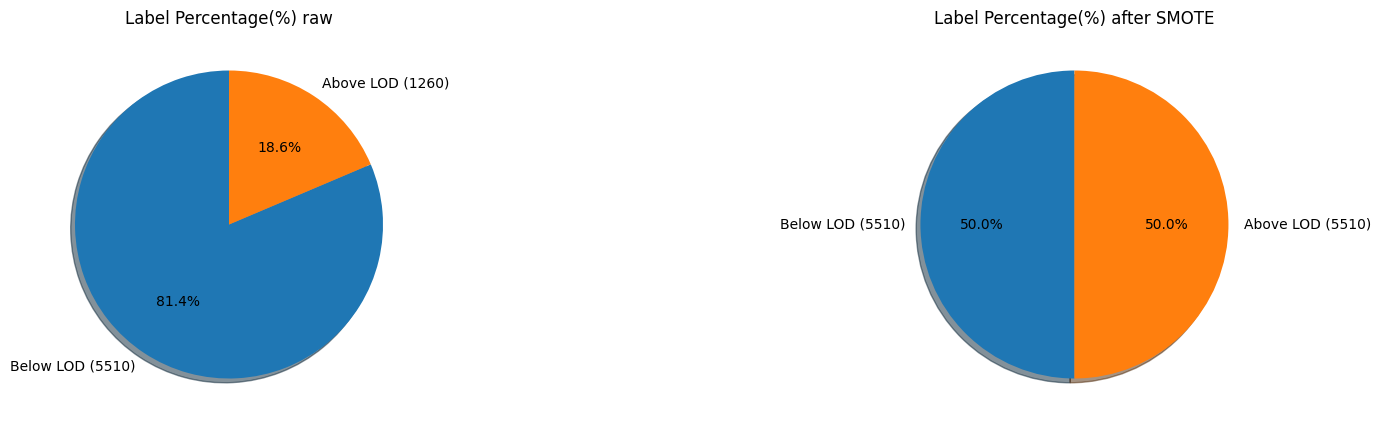

In [13]:

over_sample = SMOTE()
X_TRAIN_SMOTE, Y_TRAIN_SMOTE = over_sample.fit_resample(X_TRAIN, Y_TRAIN)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

y_train_smote = np.unique(Y_TRAIN_SMOTE, return_counts = True)
y_train_raw = np.unique(Y_TRAIN, return_counts = True)

axes[0].pie(y_train_raw[1], labels=[f'Below LOD ({y_train_raw[1][0]})', f'Above LOD ({y_train_raw[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%) raw')

axes[1].pie(y_train_smote[1], labels=[f'Below LOD ({y_train_smote[1][0]})', f'Above LOD ({y_train_smote[1][1]})'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%) after SMOTE')

Text(0.5, 1.0, 'Spectra NIR after SMOTE')

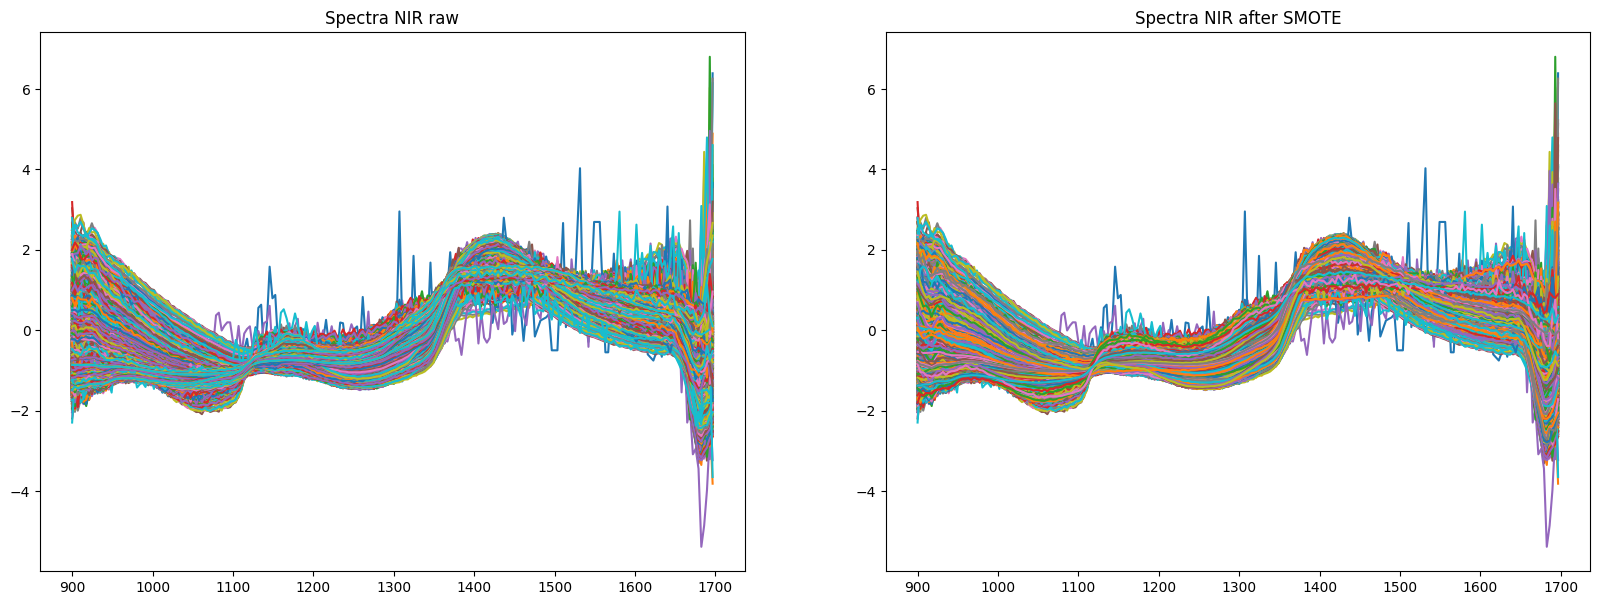

In [14]:
wl = np.arange(900, 1700, 800/228)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,7))
for i in range(X_TRAIN.shape[0]):
    axes[0].plot(wl, X_TRAIN.iloc[i,:])
axes[0].set_title('Spectra NIR raw')

for i in range(X_TRAIN_SMOTE.shape[0]):
    axes[1].plot(wl, X_TRAIN_SMOTE.iloc[i,:])
axes[1].set_title('Spectra NIR after SMOTE')


Chia dữ liệu TEST (không dùng SMOTE)

Text(0.5, 1.0, 'Count of label')

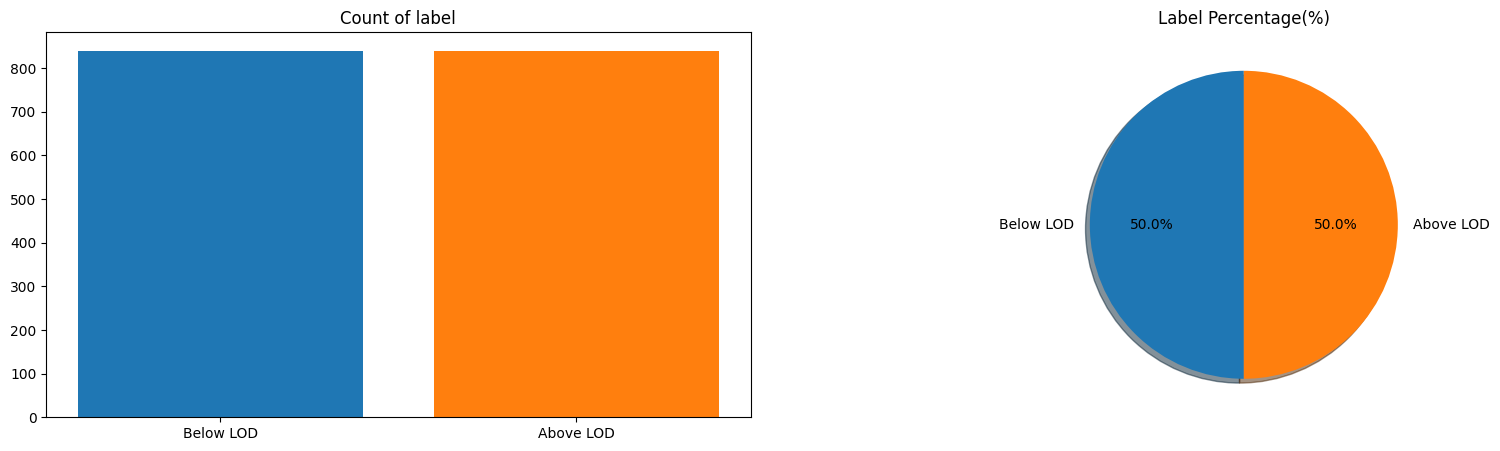

In [15]:
X_TEST = test_data.iloc[:,-N_WAVELENGTH:]
Y_TEST = np.where(test_data['Urea'] >= LOD_URE, 1, 0)
y_test_raw = np.unique(Y_TEST, return_counts = True)

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(y_test_raw[1], labels=['Below LOD', 'Above LOD'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(y_test_raw[0], y_test_raw[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

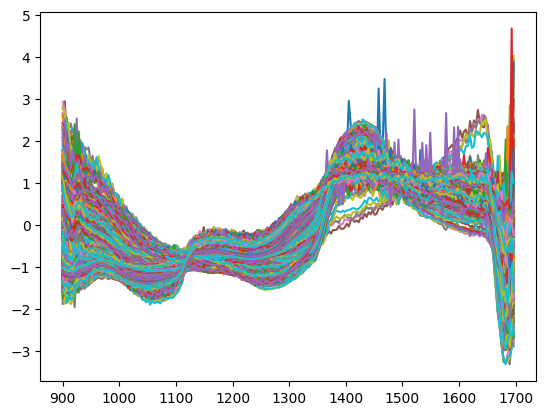

In [16]:
wl = np.arange(900, 1700, 800/228)
for i in range(X_TEST.shape[0]):
    plt.plot(wl, X_TEST.iloc[i,:])

In [17]:
# dữ liệu train và test
all_data_raw = pd.concat([train_data, test_data], axis=0)

# dữ liệu train và test đã dùng SMOTE
X_DATA = pd.concat([X_TRAIN_SMOTE, X_TEST], axis=0)
Y_DATA = np.hstack((Y_TRAIN_SMOTE, Y_TEST))

# Tiền xử lý

Savizky-Golay 

In [18]:
def my_SG(X, deriv=0):
    X_SG = savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)
    return pd.DataFrame(X_SG)

In [19]:
def snv(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T

    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_input = pd.DataFrame(df_input)
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


In [20]:
def my_preprocess_data(X_train, y_train, X_test, y_test, feature='sg0', normalization = 'msc'):
    X_train_prep = X_train
    X_test_prep = X_test
    if normalization == 'msc':
        X_train_prep = msc(X_train)
        X_test_prep = msc(X_test)
    elif normalization == 'snv':
        X_train_prep = snv(X_train)
        X_test_prep = snv(X_test)
    elif normalization == 'minmax':
        X_train_prep = my_MinMaxScaler(X_train)
        X_test_prep = my_MinMaxScaler(X_test)
    elif normalization == 'robust':
        X_train_prep = my_RobustScaler(X_train)
        X_test_prep = my_RobustScaler(X_test)
        
    if feature == 'sg0':
        X_train_prep = my_SG(X_train_prep, 0)
        X_test_prep = my_SG(X_test_prep, 0)
    elif feature == 'sg1':
        X_train_prep = my_SG(X_train_prep, 1)
        X_test_prep = my_SG(X_test_prep, 1)
    elif feature == 'sg2':
        X_train_prep = my_SG(X_train_prep, 2)
        X_test_prep = my_SG(X_test_prep, 2)
    elif feature == 'sg1 + sg2':
        X_train_SG1 = my_SG(X_train_prep, 1)
        X_train_SG2 = my_SG(X_train_prep, 2)
        X_train_prep = np.hstack([X_train_SG1, X_train_SG2])
        
        X_test_SG1 = my_SG(X_test_prep, 1)
        X_test_SG2 = my_SG(X_test_prep, 2)
        X_test_prep = np.hstack([X_test_SG1, X_test_SG2])
        
    return X_train_prep, y_train, X_test_prep, y_test

# best K 

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def get_optimal_wavelength(X, y, top_n_features=10):
    best_features = SelectKBest(score_func=f_classif, k=top_n_features)
    fit = best_features.fit(X, y)

    return list(fit.get_feature_names_out())

# KNN

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


In [32]:
acc_max = 0
optimal_n_neighbors = 0
n_optimal_wavelength_knn = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 12 for i in n_wavelength]
    
    for k in range(3,42,2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
        y_pred_knn = knn.predict(X_TEST.iloc[:,n_wavelength])
        acc = accuracy_score(Y_TEST, y_pred_knn)
        
        if acc > acc_max:
            acc_max = acc
            optimal_n_neighbors = k
            n_optimal_wavelength_knn = n_wavelength
print(acc_max, len(n_optimal_wavelength_knn), optimal_n_neighbors)

0.6845238095238095 50 25


In [33]:
knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
knn.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
y_pred_knn = knn.predict(X_TEST)
accuracy_score(Y_TEST, y_pred_knn)

0.6333333333333333

In [34]:
print(f'Parameter for KNN, k = {optimal_n_neighbors}')

Parameter for KNN, k = 25


In [35]:
def my_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [36]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_knn = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_knn]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_knn]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        acc = my_KNN(X_train, y_train, X_test, y_test)
        print(acc)
        acc_knn.append(acc)

66.012
66.905
65.417
64.762
65.06
64.524
64.345
63.154999999999994
60.297999999999995
61.845000000000006
63.512
59.940000000000005
64.464
63.81
64.524
63.095


# Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [50]:
best_criterion = ''
best_acc = 0
best_max_depth = 0
best_min_samples_leaf = 0
for criterion in ['gini', 'entropy']:
    for depth in range(3, 20):
        for samples_leaf in range(3, 20):
            dtc = DecisionTreeClassifier(criterion=criterion, max_depth=depth, min_samples_leaf=samples_leaf)
            dtc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
            y_pred_dtc = dtc.predict(X_TEST)
            acc = accuracy_score(Y_TEST, y_pred_dtc)
            
            if acc > best_acc:
                best_acc = acc
                best_criterion = criterion
                best_max_depth = depth
                best_min_samples_leaf = samples_leaf
                
print(f'best accuracy: {best_acc} with criterion: {best_criterion} max_depth: {best_max_depth} best_min_samples_leaf: {best_min_samples_leaf}')

best accuracy: 0.6440476190476191 with criterion: gini max_depth: 5 best_min_samples_leaf: 7


In [82]:
best_acc2 = 0
n_optimal_wavelength_dt = []
for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 12 for i in n_wavelength]

    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred_dtc = dtc.predict(X_TEST.iloc[:,n_wavelength])
    acc = accuracy_score(Y_TEST, y_pred_dtc)
    
    if acc > best_acc2:
        best_acc2 = acc
        n_optimal_wavelength_dt = n_wavelength
        
print(best_acc2, len(n_optimal_wavelength_dt))

0.6571428571428571 70


In [83]:
def my_DecisionTree(X_train, y_train, X_test, y_test):
     
    dtc = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, 
                                 min_samples_leaf=best_min_samples_leaf)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100
    
    return acc

In [84]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

acc_dt = []
for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_dt]
        X_test = X_TEST.iloc[:,n_optimal_wavelength_dt]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train, Y_TRAIN_SMOTE, X_test, 
                                                              Y_TEST,feature=feature, normalization=normal)
        acc = my_DecisionTree(X_train, y_train, X_test, y_test)
        print(acc)
        acc_dt.append(acc)

63.63100000000001
64.524
57.679
59.583
64.286
57.916999999999994
65.417
60.595
58.571
61.25000000000001
65.476
62.917
61.548
59.762
62.202
59.524


# Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
best_acc_rfc = 0
best_n_estimators = 0

for n_tree in range(100,301,10):
    rfc = RandomForestClassifier(n_estimators=n_tree, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST)
    acc_rfc = accuracy_score(Y_TEST, y_pred)
    if acc_rfc > best_acc_rfc:
        best_acc_rfc = acc_rfc
        best_n_estimators = n_tree
    print(n_tree, acc_rfc)

100 0.6464285714285715
110 0.6625
120 0.6571428571428571
130 0.6601190476190476
140 0.6571428571428571
150 0.6654761904761904
160 0.6613095238095238
170 0.6535714285714286
180 0.6642857142857143
190 0.6589285714285714
200 0.6529761904761905
210 0.6660714285714285
220 0.6488095238095238
230 0.6541666666666667
240 0.6607142857142857
250 0.6571428571428571
260 0.6601190476190476
270 0.656547619047619
280 0.6553571428571429
290 0.6613095238095238
300 0.655952380952381


In [53]:
print(best_acc_rfc, best_n_estimators)

0.6660714285714285 210


In [70]:
best_acc_rfc2 = 0
n_optimal_wavelength_rf = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 12 for i in n_wavelength]
    
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = rfc.predict(X_TEST.iloc[:,n_wavelength])
    acc_rfc2 = accuracy_score(Y_TEST, y_pred)
    print(acc_rfc2, len(n_wavelength))
    if acc_rfc2 > best_acc_rfc2:
        best_acc_rfc2 = acc_rfc2
        n_optimal_wavelength_rf = n_wavelength
        
print(best_acc_rfc2, len(n_optimal_wavelength_rf))
    

0.6333333333333333 10
0.6672619047619047 30
0.6785714285714286 50
0.669047619047619 70
0.6791666666666667 90
0.6648809523809524 110
0.6672619047619047 130
0.6630952380952381 150
0.656547619047619 170
0.6625 190
0.6791666666666667 90


In [78]:
def my_RandomForest(X_train, y_train, X_test, y_test):
        
    rfc = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth,
                                    min_samples_leaf=best_min_samples_leaf)
    rfc.fit(X_train, y_train.ravel())

    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return acc

In [80]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_rf]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_rf]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_RandomForest(X_train, y_train, X_test, y_test))

0.6886904761904762
0.6892857142857143
0.6375
0.675
0.6857142857142857
0.6886904761904762
0.6654761904761904
0.6523809523809524
0.6601190476190476
0.6589285714285714
0.6607142857142857
0.6583333333333333
0.6821428571428572
0.6833333333333333
0.6654761904761904
0.6494047619047619


# SVM

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
best_acc_svm = 0
best_c = 0
best_kernel = ''

for kernel in ['linear', 'poly', 'rbf']:
    for c in range(-3,4):
        svc = SVC(kernel=kernel, C=10**int(c)) 
        svc.fit(X_TRAIN_SMOTE, Y_TRAIN_SMOTE)
        y_pred = svc.predict(X_TEST)
        acc = accuracy_score(Y_TEST, y_pred)
        
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_c = 10**int(c)
            best_kernel = kernel
        

In [154]:
print(f'kernel: {best_kernel}, C: {best_c} => accuracy: {best_acc_svm}')

kernel: rbf, C: 1000 => accuracy: 0.7285714285714285


In [41]:
best_acc_svm = 0
n_optimal_wavelength_svm = []

for n_wl in range(10, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 12 for i in n_wavelength]
    
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_TRAIN_SMOTE.iloc[:,n_wavelength], Y_TRAIN_SMOTE)
    y_pred = svc.predict(X_TEST.iloc[:,n_wavelength])
    acc_svm = accuracy_score(Y_TEST, y_pred)

    if acc_svm > best_acc_svm:
        best_acc_svm = acc_svm
        n_optimal_wavelength_svm = n_wavelength
        
print(best_acc_svm, len(n_optimal_wavelength_svm))

0.7261904761904762 170


In [31]:
def my_SVM(X_train, y_train, X_test, y_test):
    svc = SVC(kernel=best_kernel, C=best_c) 
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [44]:
# Sử dụng tất cả các đặc trưng
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:

        X_train_ = X_TRAIN_SMOTE
        X_test_ = X_TEST
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, Y_TRAIN_SMOTE, X_test_, 
                                                              Y_TEST,feature=feature, normalization=normal)
        print(my_SVM(X_train, y_train, X_test, y_test))

73.452
74.405
73.333
72.262
69.762
68.69
68.869
68.512
69.048
70.0
69.286
69.762
69.524
68.393
68.75
68.452


# CNN

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, Activation, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [15]:
from keras.utils.np_utils import to_categorical
y_train_smote_encode = to_categorical(Y_TRAIN_SMOTE, num_classes = 2)
y_test_encode = to_categorical(Y_TEST, num_classes = 2)

In [18]:
def my_CNN(X_train_val, y_train_val, X_test, y_test):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size = 0.25, random_state=42)
    
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train_val.shape[1],1)),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=32, kernel_size=5, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),
        
        Conv1D(filters=64, kernel_size=11, activation='relu'),
        MaxPool1D(pool_size=2, strides=2),
        Dropout(0.01),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.01),
        Dense(2,activation='softmax')
    ])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.000001, verbose = 1)
    early_stop = EarlyStopping(patience=50)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    his = model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stop, learning_rate_reduction])
    
    evaluate_train = model.evaluate(X_train, y_train)
    evaluate_val = model.evaluate(X_val, y_val)
    evaluate_test = model.evaluate(X_test, y_test)
    
    return his, evaluate_train[1], evaluate_val[1], evaluate_test[1]

In [19]:
my_CNN(X_TRAIN_SMOTE, y_train_smote_encode, X_TEST, y_test_encode)


Epoch 1/1000
130/130 [==============================] - 2s 13ms/step - loss: 0.6898 - accuracy: 0.5324 - val_loss: 0.6818 - val_accuracy: 0.5764 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6796 - accuracy: 0.5666 - val_loss: 0.6681 - val_accuracy: 0.5866 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6611 - accuracy: 0.5898 - val_loss: 0.6444 - val_accuracy: 0.5989 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6472 - accuracy: 0.6129 - val_loss: 0.6445 - val_accuracy: 0.6105 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6344 - accuracy: 0.6264 - val_loss: 0.6243 - val_accuracy: 0.6334 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 2s 12ms/step - loss: 0.6154 - accuracy: 0.6394 - val_loss: 0.6220 - val_accuracy: 0.6341 - lr: 5.0000e-04
Epoch 7/1000
130/130 [======

(<keras.callbacks.History at 0x222580ad850>,
 0.9995160102844238,
 0.9571687579154968,
 0.6565476059913635)

In [20]:
best_acc_cnn = 0
n_optimal_wavelength_cnn = []
for n_wl in range(70, 201, 20):
    n_wavelength = get_optimal_wavelength(X_DATA, Y_DATA, n_wl)
    n_wavelength = [int(i) - 12 for i in n_wavelength]
        
    result = my_CNN(X_TRAIN_SMOTE.iloc[:, n_wavelength], y_train_smote_encode, X_TEST.iloc[:, n_wavelength], y_test_encode)
    evaluate_test = result[3]
    if evaluate_test > best_acc_cnn:
        best_acc_cnn = evaluate_test
        n_optimal_wavelength_cnn = n_wavelength

Epoch 1/1000
130/130 [==============================] - 1s 6ms/step - loss: 0.6876 - accuracy: 0.5382 - val_loss: 0.6880 - val_accuracy: 0.5430 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 1s 4ms/step - loss: 0.6824 - accuracy: 0.5584 - val_loss: 0.6770 - val_accuracy: 0.5768 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 1s 5ms/step - loss: 0.6698 - accuracy: 0.5819 - val_loss: 0.6682 - val_accuracy: 0.5989 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 1s 5ms/step - loss: 0.6598 - accuracy: 0.6007 - val_loss: 0.6643 - val_accuracy: 0.6029 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6005 - val_loss: 0.6516 - val_accuracy: 0.6094 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 5ms/step - loss: 0.6418 - accuracy: 0.6138 - val_loss: 0.6491 - val_accuracy: 0.5942 - lr: 5.0000e-04
Epoch 7/1000
130/130 [============

In [21]:
print(f'best accuracy: {best_acc_cnn}, number of optimal wavelength {len(n_optimal_wavelength_cnn)}')

best accuracy: 0.6625000238418579, number of optimal wavelength 110


In [23]:
my_CNN(X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn], y_train_smote_encode, X_TEST.iloc[:,n_optimal_wavelength_cnn], y_test_encode)

Epoch 1/1000
130/130 [==============================] - 2s 9ms/step - loss: 0.6898 - accuracy: 0.5292 - val_loss: 0.6848 - val_accuracy: 0.5350 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 1s 7ms/step - loss: 0.6783 - accuracy: 0.5678 - val_loss: 0.6754 - val_accuracy: 0.5673 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 1s 7ms/step - loss: 0.6714 - accuracy: 0.5832 - val_loss: 0.6676 - val_accuracy: 0.5858 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 1s 7ms/step - loss: 0.6648 - accuracy: 0.5871 - val_loss: 0.6624 - val_accuracy: 0.5942 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 7ms/step - loss: 0.6590 - accuracy: 0.5946 - val_loss: 0.6635 - val_accuracy: 0.5800 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 7ms/step - loss: 0.6537 - accuracy: 0.5938 - val_loss: 0.6425 - val_accuracy: 0.6091 - lr: 5.0000e-04
Epoch 7/1000
130/130 [============

(<keras.callbacks.History at 0x222821bb650>,
 0.9996370077133179,
 0.9313974380493164,
 0.6505952477455139)

In [24]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']
HISTORY = []

for normal in all_normalization:
    X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
    X_test_ = X_TEST.iloc[:,n_optimal_wavelength_cnn]
    X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, y_train_smote_encode, X_test_, 
                                                            y_test_encode,feature='sg0', normalization=normal)
    HISTORY.append(my_CNN(X_train, y_train, X_test, y_test))

Epoch 1/1000
130/130 [==============================] - 2s 10ms/step - loss: 0.6890 - accuracy: 0.5355 - val_loss: 0.6887 - val_accuracy: 0.5325 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 1s 8ms/step - loss: 0.6827 - accuracy: 0.5679 - val_loss: 0.6772 - val_accuracy: 0.5768 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6740 - accuracy: 0.5764 - val_loss: 0.6683 - val_accuracy: 0.5891 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6709 - accuracy: 0.5854 - val_loss: 0.6618 - val_accuracy: 0.5924 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6654 - accuracy: 0.5878 - val_loss: 0.6653 - val_accuracy: 0.5946 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6605 - accuracy: 0.6017 - val_loss: 0.6469 - val_accuracy: 0.6185 - lr: 5.0000e-04
Epoch 7/1000
130/130 [===========

In [25]:
for normal in all_normalization:
    X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
    X_test_ = X_TEST.iloc[:,n_optimal_wavelength_cnn]
    X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, y_train_smote_encode, X_test_, 
                                                            y_test_encode,feature='sg1', normalization=normal)
    HISTORY.append(my_CNN(X_train, y_train, X_test, y_test))

Epoch 1/1000
130/130 [==============================] - 2s 10ms/step - loss: 0.6854 - accuracy: 0.5596 - val_loss: 0.6709 - val_accuracy: 0.5920 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6694 - accuracy: 0.5856 - val_loss: 0.6616 - val_accuracy: 0.6091 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6586 - accuracy: 0.5990 - val_loss: 0.6471 - val_accuracy: 0.6138 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6520 - accuracy: 0.6070 - val_loss: 0.6411 - val_accuracy: 0.6178 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6447 - accuracy: 0.6183 - val_loss: 0.6412 - val_accuracy: 0.6287 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6362 - accuracy: 0.6290 - val_loss: 0.6367 - val_accuracy: 0.6454 - lr: 5.0000e-04
Epoch 7/1000
130/130 [===========

In [27]:
for feature in ['sg2', 'sg1 + sg2']:
    for normal in all_normalization:
        X_train_ = X_TRAIN_SMOTE.iloc[:,n_optimal_wavelength_cnn]
        X_test_ = X_TEST.iloc[:,n_optimal_wavelength_cnn]
        X_train, y_train, X_test, y_test = my_preprocess_data(X_train_, y_train_smote_encode, X_test_, 
                                                                y_test_encode,feature=feature, normalization=normal)
        HISTORY.append(my_CNN(X_train, y_train, X_test, y_test))

Epoch 1/1000
130/130 [==============================] - 2s 10ms/step - loss: 0.6907 - accuracy: 0.5232 - val_loss: 0.6774 - val_accuracy: 0.5775 - lr: 5.0000e-04
Epoch 2/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6717 - accuracy: 0.5833 - val_loss: 0.6619 - val_accuracy: 0.6058 - lr: 5.0000e-04
Epoch 3/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6633 - accuracy: 0.6011 - val_loss: 0.6654 - val_accuracy: 0.6022 - lr: 5.0000e-04
Epoch 4/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6595 - accuracy: 0.6024 - val_loss: 0.6534 - val_accuracy: 0.6123 - lr: 5.0000e-04
Epoch 5/1000
130/130 [==============================] - 1s 9ms/step - loss: 0.6554 - accuracy: 0.6106 - val_loss: 0.6521 - val_accuracy: 0.6145 - lr: 5.0000e-04
Epoch 6/1000
130/130 [==============================] - 1s 8ms/step - loss: 0.6513 - accuracy: 0.6082 - val_loss: 0.6733 - val_accuracy: 0.5982 - lr: 5.0000e-04
Epoch 7/1000
130/130 [===========

In [28]:
for i in HISTORY:
    print([np.round(x,5)*100 for x in i[1:]])

[99.201, 91.289, 65.476]
[99.335, 91.97800000000001, 64.881]
[98.657, 93.612, 63.81]
[98.76599999999999, 90.345, 65.119]
[99.734, 92.66799999999999, 64.762]
[98.923, 91.289, 64.94]
[99.53999999999999, 92.269, 64.107]
[99.298, 90.59899999999999, 65.298]
[98.463, 89.546, 62.798]
[98.705, 89.328, 62.73800000000001]
[97.072, 87.586, 62.917]
[99.25, 90.526, 61.726000000000006]
[99.601, 92.704, 63.690000000000005]
[99.431, 92.305, 64.702]
[98.98400000000001, 91.54299999999999, 64.405]
[99.286, 92.849, 65.476]


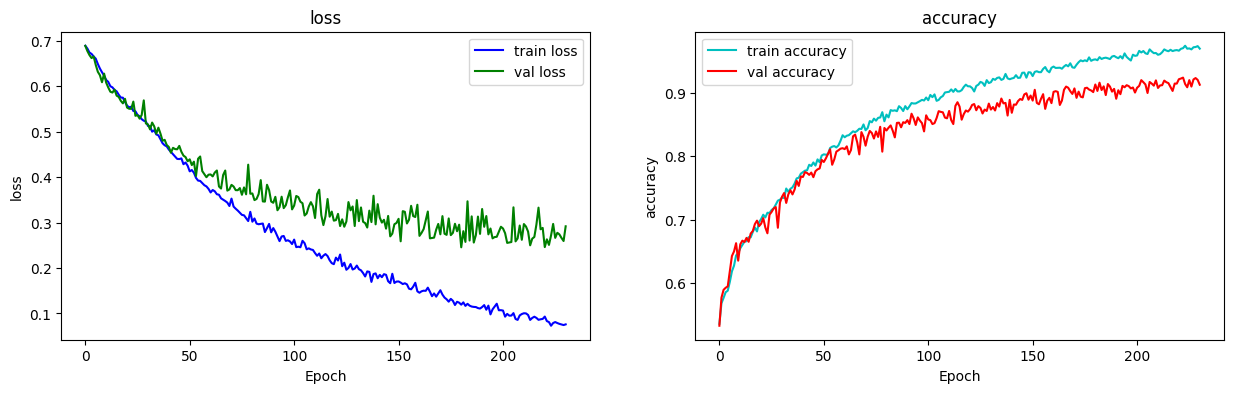

In [68]:
s, (at, al) = plt.subplots(1, 2, figsize=(15,4))

at.plot(HISTORY[0][0].history['loss'], 'b', label='train loss')
at.plot(HISTORY[0][0].history['val_loss'], 'g', label='val loss')
at.set_title('loss')
at.set_xlabel('Epoch')
at.set_ylabel('loss')
at.legend()

al.plot(HISTORY[0][0].history['accuracy'], 'c', label='train accuracy')
al.plot(HISTORY[0][0].history['val_accuracy'], 'r', label='val accuracy')
al.set_title('accuracy')
al.set_xlabel('Epoch')
al.set_ylabel('accuracy')
al.legend()

# Sử dụng mô hình SVM (tốt nhất) để đánh giá độ chính xác các vị trí của cá

# repeated hold out

In [27]:
TIME_REPEAT_HOLD_OUT = 10
result = {}
for times in range(TIME_REPEAT_HOLD_OUT):
    accuracy_each_position = []
    
    test_fish_id = get_random_test_fish_id(df)
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    for position in list(test_data['Vị trí đo'].unique()):

        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_Y_TEST = np.where(sub_data_TEST['Urea'] > LOD_URE, 1, 0)

        X_train, y_train, X_test, y_test = my_preprocess_data(X_TRAIN_SMOTE, Y_TRAIN_SMOTE, sub_X_TEST, 
                                                                sub_Y_TEST,feature='sg0', normalization='snv')
        
        svm = SVC(kernel=best_kernel, C=best_c) 
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accuracy_each_position.append(acc)
        print(f'Lần: {times+1}, Vị trí : {position}  ==>  độ chính xác: {acc}')
    result[times] = accuracy_each_position

Lần: 1, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.65
Lần: 1, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.6928571428571428
Lần: 1, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.8
Lần: 1, Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.8214285714285714
Lần: 1, Vị trí : Mang 1  ==>  độ chính xác: 0.6571428571428571
Lần: 1, Vị trí : Mang 2  ==>  độ chính xác: 0.6642857142857143
Lần: 1, Vị trí : Mắt 1  ==>  độ chính xác: 0.6357142857142857
Lần: 1, Vị trí : Mắt 2  ==>  độ chính xác: 0.7857142857142857
Lần: 1, Vị trí : Trong thịt, gáy  ==>  độ chính xác: 0.7428571428571429
Lần: 1, Vị trí : Trong thịt, lưng  ==>  độ chính xác: 0.7285714285714285
Lần: 1, Vị trí : Trong thịt, đuôi  ==>  độ chính xác: 0.6071428571428571
Lần: 1, Vị trí : Trong thịt, bụng  ==>  độ chính xác: 0.6428571428571429
Lần: 2, Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.75
Lần: 2, Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.6571428571428571
Lần: 2, Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.7214285714285714
Lần: 2,

In [31]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    acc = 0
    for j in range(TIME_REPEAT_HOLD_OUT):
        acc += result[j][i]
    print(f'Vị trí : {position}  ==>  độ chính xác trung binh: {acc/TIME_REPEAT_HOLD_OUT}')

Vị trí : Ngoài da, gáy  ==>  độ chính xác trung binh: 0.72
Vị trí : Ngoài da, lưng  ==>  độ chính xác trung binh: 0.6621428571428571
Vị trí : Ngoài da, đuôi  ==>  độ chính xác trung binh: 0.7100000000000001
Vị trí : Ngoài da, bụng  ==>  độ chính xác trung binh: 0.72
Vị trí : Mang 1  ==>  độ chính xác trung binh: 0.6135714285714287
Vị trí : Mang 2  ==>  độ chính xác trung binh: 0.675
Vị trí : Mắt 1  ==>  độ chính xác trung binh: 0.5842857142857142
Vị trí : Mắt 2  ==>  độ chính xác trung binh: 0.650435663627153
Vị trí : Trong thịt, gáy  ==>  độ chính xác trung binh: 0.636439962914783
Vị trí : Trong thịt, lưng  ==>  độ chính xác trung binh: 0.6385714285714286
Vị trí : Trong thịt, đuôi  ==>  độ chính xác trung binh: 0.6002988855116514
Vị trí : Trong thịt, bụng  ==>  độ chính xác trung binh: 0.6042857142857143


# Cross validation

In [34]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 5
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=1)
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df['Urea'].iloc[1])
    
y_labels = np.where(np.array(ure_value) >= LOD_URE, 1, 0)

In [33]:
result_cv = {}
list_confuse_matrix_cv = {}

for times, (train_index, test_index) in enumerate(skf.split(ure_value, y_labels)):
    accuracy_each_position = []
    confuse_matrix_each_position = []
    
    test_fish_id = fish_numbers[test_index]
    train_data, test_data = train_smote_and_test_by_test_fish_id(df, test_fish_id)
    X_TRAIN_SMOTE, Y_TRAIN_SMOTE, X_TEST, Y_TEST = my_split_train_test(train_data, test_data)
    
    for position in list(test_data['Vị trí đo'].unique()):
        sub_data_TEST = test_data[test_data['Vị trí đo'] == position]
        sub_X_TEST = sub_data_TEST.iloc[:, -N_WAVELENGTH:]
        sub_Y_TEST = np.where(sub_data_TEST['Urea'] > LOD_URE, 1, 0)
        
        X_train, y_train, X_test, y_test = my_preprocess_data(X_TRAIN_SMOTE, Y_TRAIN_SMOTE, sub_X_TEST, 
                                                                sub_Y_TEST,feature='sg0', normalization='snv')
    
        svm = SVC(kernel=best_kernel, C=best_c) 
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        accuracy_each_position.append(acc)
        confuse_matrix_each_position.append(metrics.confusion_matrix(sub_Y_TEST, y_pred))
        print(f'Vị trí : {position}  ==>  độ chính xác: {acc}')
        
    result_cv[times] = accuracy_each_position
    list_confuse_matrix_cv[times] = confuse_matrix_each_position
    print('='*30)

Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.7172413793103448
Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.6827586206896552
Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.7724137931034483
Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.7034482758620689
Vị trí : Mang 1  ==>  độ chính xác: 0.5793103448275863
Vị trí : Mang 2  ==>  độ chính xác: 0.7586206896551724
Vị trí : Mắt 1  ==>  độ chính xác: 0.5862068965517241
Vị trí : Mắt 2  ==>  độ chính xác: 0.7310344827586207
Vị trí : Trong thịt, gáy  ==>  độ chính xác: 0.6275862068965518
Vị trí : Trong thịt, lưng  ==>  độ chính xác: 0.5714285714285714
Vị trí : Trong thịt, đuôi  ==>  độ chính xác: 0.6142857142857143
Vị trí : Trong thịt, bụng  ==>  độ chính xác: 0.7214285714285714
Vị trí : Ngoài da, gáy  ==>  độ chính xác: 0.6071428571428571
Vị trí : Ngoài da, lưng  ==>  độ chính xác: 0.6928571428571428
Vị trí : Ngoài da, đuôi  ==>  độ chính xác: 0.7071428571428572
Vị trí : Ngoài da, bụng  ==>  độ chính xác: 0.7142857142857143
Vị trí : Mang 1  ==> 

In [41]:
for i, position in enumerate(list(df['Vị trí đo'].unique())):
    sub_list_acc = []
    for j in range(K_FOLD):
        acc = result_cv[j][i]
        sub_list_acc.append(acc)
    print('Vị trí : {}  ==>  độ chính xác trung binh: {:.3f}'.format(position, np.mean(sub_list_acc)*100))

Vị trí : Ngoài da, gáy  ==>  độ chính xác trung binh: 71.488
Vị trí : Ngoài da, lưng  ==>  độ chính xác trung binh: 71.655
Vị trí : Ngoài da, đuôi  ==>  độ chính xác trung binh: 78.305
Vị trí : Ngoài da, bụng  ==>  độ chính xác trung binh: 76.069
Vị trí : Mang 1  ==>  độ chính xác trung binh: 63.729
Vị trí : Mang 2  ==>  độ chính xác trung binh: 68.030
Vị trí : Mắt 1  ==>  độ chính xác trung binh: 61.010
Vị trí : Mắt 2  ==>  độ chính xác trung binh: 68.380
Vị trí : Trong thịt, gáy  ==>  độ chính xác trung binh: 66.141
Vị trí : Trong thịt, lưng  ==>  độ chính xác trung binh: 65.857
Vị trí : Trong thịt, đuôi  ==>  độ chính xác trung binh: 63.610
Vị trí : Trong thịt, bụng  ==>  độ chính xác trung binh: 60.857


In [68]:
# list_confuse_matrix_cv[1][2]
confuse_matrix = []
for i in range(K_FOLD):
    matrix = list_confuse_matrix_cv[i][2]
    confuse_matrix.append(np.array(matrix))
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][1]
    fn = matrix[1][0]
    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    f1_score = (2*precision*recall)/(precision + recall)
print(sum(confuse_matrix))

[[439  91]
 [ 62 113]]


<Axes: >

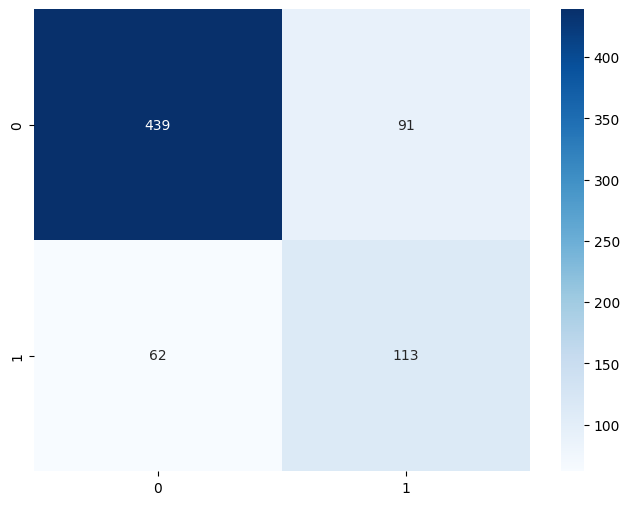

In [90]:
import seaborn as sn
plt.figure(figsize = (8,6))
df_cm = pd.DataFrame(sum(confuse_matrix), range(2), range(2))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [67]:

confuse_matrix = []
for i in range(K_FOLD):
    matrix = list_confuse_matrix_cv[i][3]
    confuse_matrix.append(np.array(matrix))
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][1]
    fn = matrix[1][0]
    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    f1_score = (2*precision*recall)/(precision + recall)
print(sum(confuse_matrix))

[[420 110]
 [ 59 116]]


In [ ]:
confuse_matrix = []
for i in range(K_FOLD):
    matrix = list_confuse_matrix_cv[i][2]
    confuse_matrix.append(np.array(matrix))
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][1]
    fn = matrix[1][0]
    precision = tp / (tp + fp)
    recall =  tp / (tp + fn)
    f1_score = (2*precision*recall)/(precision + recall)
    print(f1_score)

In [60]:
matrix = list_confuse_matrix_cv[1][2]
print(matrix)
print(matrix[0][1])

[[92 13]
 [28  7]]
13


In [53]:
b = sum(a)/5
b

array([[87.8, 18.2],
       [12.4, 22.6]])

In [61]:
precison = b[0][0] / (b[0][0] + b[0][1])
recall =  b[0][0] / (b[0][0] + b[1][1])

print((2*precison*recall)/(precison + recall))

0.811460258780037
